# Data Analysis

In this notebook we study the error in our numerical method as well as preform various sanity checks on the results. These are:
1. Ploting the RMSv
2. Ploting the Error in Energy Conservation as a function of timestep size
3. Generating contour plots at various timesteps to compare with the results of Schaer and Wernli's paper for the initial condition of an isolated Semi-Geostrophic Cyclone. 

### Import the needed packages 

In [2]:
import numpy as np
import main as main
import erroranalysis as err
import auxfunctions as aux
import matplotlib.pyplot as plt

### Load in the Data

In [3]:
Z, C, W, M, TC = aux.load_data('./data/SG_data.msgpack')
#ZRef, CRef, WRef, MRef, TCRef = aux.load_data('./data/SG_data_ref.msgpack')
box = [-3.66, -1.75, 0, 3.66, 1.75, 0.45]

## Error Analysis

Here we investigate the Weighted Euclidian Error and the Sinkhorn loss. These are done by comparison to a "high-resolution" simulation. 

### Check the Weighted Euclidian Error

In [ ]:
euclid_error = err.Weighted_Euclidian_Error(Z, ZRef, MRef, 5, 3, box)

print(euclid_error)

### Check the Sinkhorn Loss

In [ ]:
sinkhorn_loss = err.Sqrt_Sinkhorn_Loss(Z, M, ZRef, MRef, 0.001, 5, 2.5, box)

print(sinkhorn_loss)

## Next we have our coding sanity checks

### Check the RMSv

In [ ]:
RMSv = err.Root_Mean_Squared_Velocity(ZRef, CRef, 'Zonal')

# Create a line plot
plt.plot(RMSv)

# Add labels and title
plt.xlabel('Time Step')
plt.ylabel('RMSv')
plt.title('RMSv')

plt.show()

### Checking that the Transport Cost is Conserved

In [ ]:
# Define the parameters of the system

box = [-1, -1, -1, 1, 1, 1] # List or tuple defining domain [xmin, ymin, zmin, xmax, ymax, zmax]
per_tol = 1e-3 # Percent tolerance
per_x = True # Set the periodicity of X
per_y = True # Set the periodicity of Y
per_z = False # Set the periodicity of Z
tf = 52 # Final time
Ndt = np.linspace(1000, 4200, 21, endpoint=True) # Number of timesteps
N = 10 # Number of seeds
Z = np.random.rand(N, 3) * 2 - 1 # Place the seeds randomly
data = []
counter = 0

for i in Ndt:
    main.SG_solver(box, Z, per_tol, tf, int(i), per_x, per_y, per_z, debug = False) #Solve and save the solution

    seeds, C, _, _, TC = aux.load_data('./data/SG_data.msgpack') # Load the data from the MessagePack file

    _, _, _, _, E, _ = aux.Properties(seeds, C, TC) # Compute the Velocities, Temperature, and Kinetic Energy

    meanEnergy = np.mean(E)

    ConservationError = np.abs((E - meanEnergy) / meanEnergy)

    data.append(max(ConservationError))

    counter += 1

    print(counter)

In [ ]:
# Create a line plot
plt.plot(tf * 14760 / Ndt, data)
# Add labels and title
plt.xlabel('Timestep Size (sec)')
plt.ylabel('Max Error in Energy Conservation')
plt.title('Error in Conservation of Energy vs Timestep Size')

plt.show()

print(data, tf * 14760 / Ndt)

### Contour plots of the temperature

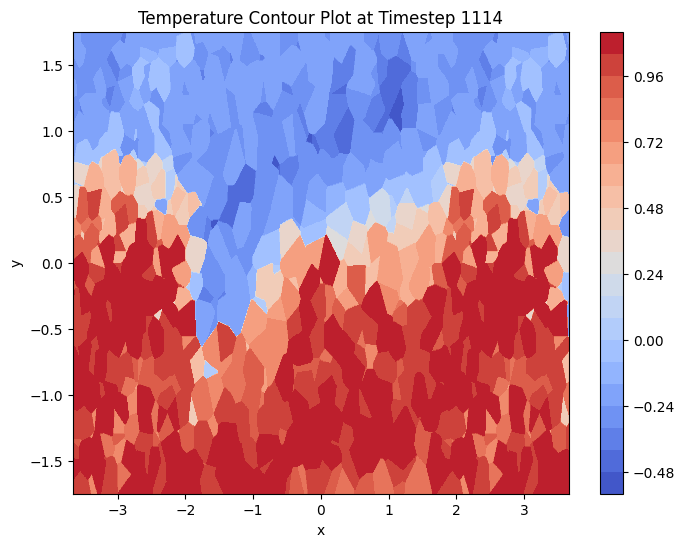

In [18]:
# Load in a package to preform a nearest neighbour search
from scipy.spatial import cKDTree

# Select the timestep you want to plot (e.g., 0 for the first timestep)
a, b, c = 3.66, 1.75, 0.45 # Pull in the dimensions of the fundamental domain
selected_timestep = 1114  # Adjust this as needed
fixed_z = c # Set whether we are ploting the temperature on the surface or on the lid

# First we compute the temperature and zip it to the corresponding centroid
_, _, _, T, _, _ = aux.Properties(Z, C, TC)
T_selected = T[selected_timestep, :, np.newaxis]  # T for selected timestep
C_selected = C[selected_timestep]  # Positions for selected timestep
CT_selected = np.concatenate((C_selected, T_selected), axis=1)  # Combine selected positions and temperatures

# Set the shift value to ensure that the copies lie in [-2a,-a] and [a,2a]
x_shift = 1.5 * a 
C_rs_selected = CT_selected.copy()
C_ls_selected = CT_selected.copy()
C_rs_selected[:, 0] += x_shift
C_ls_selected[:, 0] -= x_shift

# Combine the original and the two shifted centroid positions
combined_positions = np.vstack((CT_selected, C_rs_selected, C_ls_selected))

# Next we generate a grid containing all of the points on the surface or the lid for our contour plot. 

# Grid dimensions in x and y directions
num_points_x = 1000  # Number of points in x
num_points_y = 500   # Number of points in y

# Generate grid points for x and y
x = np.linspace(-a, a, num_points_x)
y = np.linspace(-b, b, num_points_y)

# Create meshgrid for x and y
x_grid, y_grid = np.meshgrid(x, y)

# Flatten the x and y grid arrays
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Set the z coordinate
z_flat = np.full_like(x_flat, fixed_z)  # Create an array filled with the fixed z value

# Combine x, y, and z into a Mx3 matrix
sample_points = np.vstack((x_flat, y_flat, z_flat)).T

# Nearest neighbor search for the selected timestep
tree = cKDTree(combined_positions[:, :3])  # Use positions only
distances, indices = tree.query(sample_points, k=1)
nearest_temperatures = combined_positions[indices, 3]

# Prepare sample points with temperature for plotting
sample_points_with_temp = np.hstack((sample_points, nearest_temperatures[:, np.newaxis]))
xy_temp = sample_points_with_temp[:, [0, 1, 3]]

# Reshaping and plotting as before
temperatures_grid = xy_temp[:, 2].reshape((num_points_y, num_points_x))
x_unique = np.unique(xy_temp[:, 0])
y_unique = np.unique(xy_temp[:, 1])

plt.figure(figsize=(8, 6))
cp = plt.contourf(x_unique, y_unique, temperatures_grid, cmap='coolwarm', levels=20)
plt.colorbar(cp)
plt.title(f'Temperature Contour Plot at Timestep {selected_timestep}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()